In [26]:
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
# Load the data we just saved
X_train = pd.read_csv('../data/processed/X_train_final.csv')
y_train = pd.read_csv('../data/processed/y_train_final.csv').values.ravel() # ravel() makes it a 1D array
X_test = pd.read_csv('../data/processed/X_test_final.csv')
y_test = pd.read_csv('../data/processed/y_test_final.csv').values.ravel()

print("Data loaded successfully. Let's build the models!")

Data loaded successfully. Let's build the models!


In [3]:
# Initialize and Train
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_lr = lr_model.predict(X_test)
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.70      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.75      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223



In [4]:
# Initialize and Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_rf = rf_model.predict(X_test)
print("--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf))

--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.93      0.54      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.94      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223



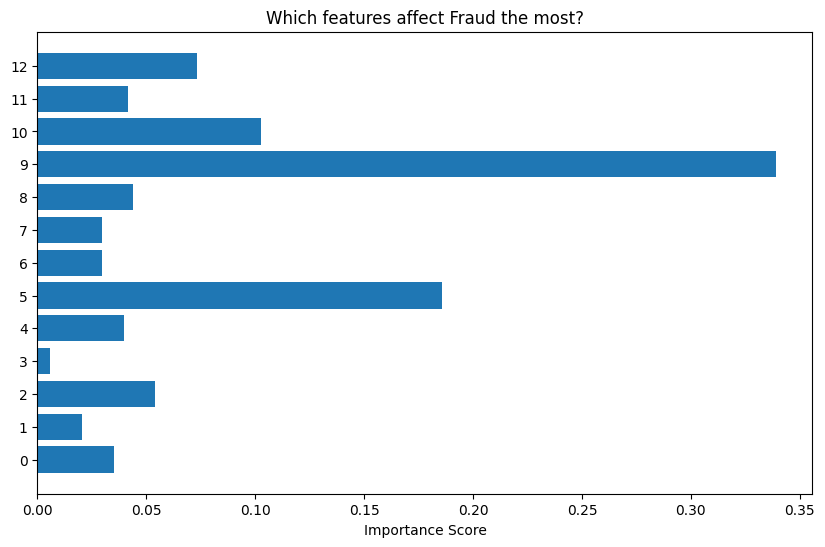

In [7]:

# Get the importance of each feature
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Visualize it
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel("Importance Score")
plt.title("Which features affect Fraud the most?")
plt.show()

In [9]:
print(X_test.head())

          0         1         2         3         4         5         6  \
0 -0.651570  1.112391  1.825854 -1.186573 -0.599468  0.796357  0.135442   
1 -0.160038 -1.127193 -0.954837 -1.186573 -1.063718  1.238464  1.044355   
2  2.516082 -1.127193  1.825854 -1.186573 -1.411905  0.819694  1.371631   
3 -0.706185  1.112391  0.435509  0.842763  1.953906 -0.903688  0.469447   
4  0.222265  1.112391 -0.954837  0.842763 -0.599468  1.311477  0.201466   

          7         8         9        10        11        12  
0  0.133089  1.268434 -0.262224 -0.233151 -1.089472 -1.503080  
1  1.044406  0.098180 -0.262224 -0.233151 -0.221319  1.486658  
2  1.372493 -0.399178  0.116844 -0.233151  1.225603 -1.503080  
3  0.467977 -0.457691 -0.262224 -0.233151 -0.800088  0.988369  
4  0.199288 -0.838024 -0.262224 -0.233151  0.212758 -1.503080  


In [11]:
# 1. Calculate AUC-PR
# We get the 'probabilities' instead of just '0 or 1'
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_rf)
auc_pr = auc(recall, precision)
print(f"Random Forest AUC-PR: {auc_pr:.4f}")

# 2. Cross-Validation (k=5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# We'll check F1-score across 5 different 'folds' of the data
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='f1')

print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")
print(f"Std Dev of CV F1-Score: {cv_scores.std():.4f}")

Random Forest AUC-PR: 0.7005
Mean CV F1-Score: 0.9716
Std Dev of CV F1-Score: 0.0007


In [14]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# 2. Set up the Search
# n_iter=5 means it will try 5 random combinations from our grid
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=param_dist, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)

# 3. Run the search
random_search.fit(X_train, y_train)

print(f"Best Settings: {random_search.best_params_}")
print(f"Best F1 Score from Tuning: {random_search.best_score_:.4f}")

Best Settings: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': None}
Best F1 Score from Tuning: 0.9661


In [15]:
# 1. Create the 'Optimized' model with the best params
optimized_rf = RandomForestClassifier(
    n_estimators=50, 
    min_samples_split=2, 
    max_depth=None, 
    random_state=42
)

# 2. Train it on the resampled data
optimized_rf.fit(X_train, y_train)

# 3. Test it on the SEPARATE test data (X_test)
y_pred_final = optimized_rf.predict(X_test)

print("--- FINAL Optimized Random Forest Results (On Test Data) ---")
print(classification_report(y_test, y_pred_final))

--- FINAL Optimized Random Forest Results (On Test Data) ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.92      0.54      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.94      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223



In [24]:

X_train_credit = pd.read_csv('../data/processed/X_train_credit.csv')
y_train_credit = pd.read_csv('../data/processed/y_train_credit.csv').values.ravel() # ravel() makes it a 1D array
X_test_credit = pd.read_csv('../data/processed/X_test_credit.csv')
y_test_credit = pd.read_csv('../data/processed/y_test_credit.csv').values.ravel()


from sklearn.utils import resample

# 1. Combine training data temporarily to sample it
train_temp = pd.concat([X_train_credit, pd.Series(y_train_credit, name='target')], axis=1)

# 2. Downsample to a manageable size (e.g., 50,000 rows total)
# This keeps the math the same but uses less memory
train_small = resample(train_temp, n_samples=50000, random_state=42, stratify=train_temp['target'])

X_train_small = train_small.drop('target', axis=1)
y_train_small = train_small['target']

# 3. Train a simpler, faster Random Forest
rf_credit = RandomForestClassifier(
    n_estimators=50,      # Fewer trees
    max_depth=10,        # Shallower trees
    n_jobs=-1,           # All CPU cores
    random_state=42
)

rf_credit.fit(X_train_small, y_train_small)

# 4. Predict on the FULL test set (no sampling here!)
y_pred_credit = rf_credit.predict(X_test_credit)

print("--- Credit Card Dataset Results (Downsampled for Speed) ---")
print(classification_report(y_test_credit, y_pred_credit))

--- Credit Card Dataset Results (Downsampled for Speed) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.45      0.84      0.59        95

    accuracy                           1.00     56746
   macro avg       0.73      0.92      0.79     56746
weighted avg       1.00      1.00      1.00     56746



Dataset,Model,Precision,Recall,F1-Score,Result Style
Fraud_Data,Logistic Regression,0.52,0.70,0.60,High False Positives
Fraud_Data,Random Forest (Best),0.92,0.54,0.68,High Reliability
Credit Card,Random Forest,0.45,0.84,0.59,High Sensitivity

In [25]:

# Save the model to a file
joblib.dump(rf_model, '../models/fraud_rf_model.pkl')
print("Model saved!")

Model saved!
